## K-Means - Create NYC Neighborhood Proxies WITH MORE NEIGHBORHOODS
### University of Virginia
### DS 5110: Big Data Systems
### By: TeamBike

In [48]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("data preprocessing") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

Read CSV I pulled from Abby's file; contains station info (lats, longs, address, etc.)

In [49]:
df = spark.read.csv('stations_fix.csv', header=True, inferSchema=True)

Remove Manhattan and Brooklyn from the DF. I want to keep these boroughs unclustered. Set to no_mb. Rename columns. 

I am also adding a dummy `prediction` column with 999. I do not want these boroughs clustered, so anything here that's not 0-3 (so we don't step on Manhattan's or BK's clusters later) will do. This makes the union easier later.

In [50]:
from pyspark.sql.functions import lit
no_mb = df.where(df.Borough != 'Manhattan').where(df.Borough != 'Brooklyn')\
.withColumn("prediction", lit(999)).withColumnRenamed('startStationLatitude', 'latitude').withColumnRenamed('startStationLongitude', 'longitude')

Create a DF that's only Brooklyn (I want to cluster Manhattan and Brooklyn individually)

In [51]:
df_brook = df.where(df.Borough=='Brooklyn').withColumnRenamed('startStationLatitude', 'latitude').withColumnRenamed('startStationLongitude', 'longitude')

Repeat for Manhattan

In [52]:
df = df.where(df.Borough=='Manhattan').withColumnRenamed('startStationLatitude', 'latitude').withColumnRenamed('startStationLongitude', 'longitude')

Check to make sure this all worked

In [53]:
no_mb.show(5)

+---+-------+--------------------+---------+------------------+----------+
|_c0|Borough|    startStationName| latitude|         longitude|prediction|
+---+-------+--------------------+---------+------------------+----------+
|  1| Queens|  21 St & Hoyt Ave S|40.774645|-73.92370600000001|       999|
|  2| Queens| Jackson Ave & 46 Rd|40.745248|-73.94733199999999|       999|
|  3|  Bronx|Wilkins Ave & Cro...|40.835302|        -73.895133|       999|
|  8|  Bronx|Fulton Ave & St. ...| 40.83545|-73.90153000000001|       999|
| 16|  Bronx|Willis Ave & E 13...|   40.809|           -73.923|       999|
+---+-------+--------------------+---------+------------------+----------+
only showing top 5 rows



In [54]:
no_mb.groupby(no_mb.Borough).count().show()

+-------+-----+
|Borough|count|
+-------+-----+
| Queens|  179|
|  Bronx|  226|
+-------+-----+



In [55]:
df_brook.show(5)

+---+--------+--------------------+------------------+------------------+
|_c0| Borough|    startStationName|          latitude|         longitude|
+---+--------+--------------------+------------------+------------------+
|  9|Brooklyn|Prospect Pl & Und...|            40.677|           -73.965|
| 12|Brooklyn|       63 St & 5 Ave|          40.63766|         -74.01782|
| 17|Brooklyn|Stewart Ave & Joh...|40.708690000000004|-73.92586999999999|
| 18|Brooklyn|Henry St & Atlant...|         40.690893|        -73.996123|
| 22|Brooklyn|       10 St & 2 Ave|         40.671907|        -73.993612|
+---+--------+--------------------+------------------+------------------+
only showing top 5 rows



In [56]:
df_brook.groupby(df_brook.Borough).count().show()

+--------+-----+
| Borough|count|
+--------+-----+
|Brooklyn|  471|
+--------+-----+



In [57]:
df.groupby(df.Borough).count().show()

+---------+-----+
|  Borough|count|
+---------+-----+
|Manhattan|  651|
+---------+-----+



Get data assembled and transformed for Manhattan:

In [58]:
from pyspark.ml.feature import VectorAssembler

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(df)
new_df.show(5)

+---+---------+--------------------+------------------+------------------+--------------------+
|_c0|  Borough|    startStationName|          latitude|         longitude|            features|
+---+---------+--------------------+------------------+------------------+--------------------+
|  0|Manhattan|W 84 St & Columbu...|            40.785|-73.97283399999999|[40.785,-73.97283...|
|  4|Manhattan|    E 118 St & 3 Ave|40.799139000000004|-73.93891500000001|[40.7991390000000...|
|  5|Manhattan|John St & William St|       40.70862144|        -74.007221|[40.70862144,-74....|
|  6|Manhattan|W 82 St & Central...|          40.78275|         -73.97137|[40.78275,-73.97137]|
|  7|Manhattan|     W 33 St & 7 Ave|           40.7502|         -73.99093| [40.7502,-73.99093]|
+---+---------+--------------------+------------------+------------------+--------------------+
only showing top 5 rows



In [59]:
new_brook = vecAssembler.transform(df_brook)
new_brook.show(5)

+---+--------+--------------------+------------------+------------------+--------------------+
|_c0| Borough|    startStationName|          latitude|         longitude|            features|
+---+--------+--------------------+------------------+------------------+--------------------+
|  9|Brooklyn|Prospect Pl & Und...|            40.677|           -73.965|    [40.677,-73.965]|
| 12|Brooklyn|       63 St & 5 Ave|          40.63766|         -74.01782|[40.63766,-74.01782]|
| 17|Brooklyn|Stewart Ave & Joh...|40.708690000000004|-73.92586999999999|[40.7086900000000...|
| 18|Brooklyn|Henry St & Atlant...|         40.690893|        -73.996123|[40.690893,-73.99...|
| 22|Brooklyn|       10 St & 2 Ave|         40.671907|        -73.993612|[40.671907,-73.99...|
+---+--------+--------------------+------------------+------------------+--------------------+
only showing top 5 rows



Run K-Means on Manhattan with 5 clusters

In [60]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=5, seed=1)  # 5 clusters here
model = kmeans.fit(new_df.select('features'))

In [61]:
transformed = model.transform(new_df)
#transformed.show()

In [62]:
transformed = transformed.select([x for x in transformed.columns if x != 'features']) # remove features so I can union back to the OG data w just Queens and the Bronx

In [63]:
#transformed.show()

In [64]:
#no_manhattan.show()

I want 3 clusters for Brooklyn. Repeat clustering with k = 3 on Brooklyn data:

In [65]:
kmeans = KMeans(k=3, seed=1)  # 3 clusters here
model = kmeans.fit(new_brook.select('features'))
transformed_brook = model.transform(new_brook)

In [66]:
transformed.show(5)

+---+---------+--------------------+------------------+------------------+----------+
|_c0|  Borough|    startStationName|          latitude|         longitude|prediction|
+---+---------+--------------------+------------------+------------------+----------+
|  0|Manhattan|W 84 St & Columbu...|            40.785|-73.97283399999999|         0|
|  4|Manhattan|    E 118 St & 3 Ave|40.799139000000004|-73.93891500000001|         2|
|  5|Manhattan|John St & William St|       40.70862144|        -74.007221|         3|
|  6|Manhattan|W 82 St & Central...|          40.78275|         -73.97137|         0|
|  7|Manhattan|     W 33 St & 7 Ave|           40.7502|         -73.99093|         4|
+---+---------+--------------------+------------------+------------------+----------+
only showing top 5 rows



In [67]:
transformed_brook = transformed_brook.select([x for x in transformed_brook.columns if x != 'features']) # remove features so I can union back to the OG data w just Queens and the Bronx

In [68]:
transformed_brook.show(5)

+---+--------+--------------------+------------------+------------------+----------+
|_c0| Borough|    startStationName|          latitude|         longitude|prediction|
+---+--------+--------------------+------------------+------------------+----------+
|  9|Brooklyn|Prospect Pl & Und...|            40.677|           -73.965|         1|
| 12|Brooklyn|       63 St & 5 Ave|          40.63766|         -74.01782|         2|
| 17|Brooklyn|Stewart Ave & Joh...|40.708690000000004|-73.92586999999999|         0|
| 18|Brooklyn|Henry St & Atlant...|         40.690893|        -73.996123|         1|
| 22|Brooklyn|       10 St & 2 Ave|         40.671907|        -73.993612|         2|
+---+--------+--------------------+------------------+------------------+----------+
only showing top 5 rows



Union all three DFs back together:

In [69]:
df_fin = no_mb.union(transformed).union(transformed_brook)

In [70]:
df_fin.show(5)

+---+-------+--------------------+---------+------------------+----------+
|_c0|Borough|    startStationName| latitude|         longitude|prediction|
+---+-------+--------------------+---------+------------------+----------+
|  1| Queens|  21 St & Hoyt Ave S|40.774645|-73.92370600000001|       999|
|  2| Queens| Jackson Ave & 46 Rd|40.745248|-73.94733199999999|       999|
|  3|  Bronx|Wilkins Ave & Cro...|40.835302|        -73.895133|       999|
|  8|  Bronx|Fulton Ave & St. ...| 40.83545|-73.90153000000001|       999|
| 16|  Bronx|Willis Ave & E 13...|   40.809|           -73.923|       999|
+---+-------+--------------------+---------+------------------+----------+
only showing top 5 rows



Some checks. Data are roughly balanced, or at least better than before -- and more mathematically neighborhoody:

In [71]:
from pyspark.sql import functions as F
df_fin.groupby('Borough', 'prediction').agg(F.count('prediction')).show()

+---------+----------+-----------------+
|  Borough|prediction|count(prediction)|
+---------+----------+-----------------+
|    Bronx|       999|              226|
|Manhattan|         3|              138|
| Brooklyn|         0|              183|
| Brooklyn|         1|              172|
|Manhattan|         4|              171|
|Manhattan|         0|              137|
|Manhattan|         1|               67|
|Manhattan|         2|              138|
| Brooklyn|         2|              116|
|   Queens|       999|              179|
+---------+----------+-----------------+



In [72]:
df_fin.count() # count matches back to the original data

1527

Concatenate to create the new neighborhoods. Give the name as `concat` to be boring:

In [73]:
from pyspark.sql.functions import concat
df_fin = df_fin.withColumn('concat',concat(*['Borough', 'prediction']))

In [74]:
df_fin.show(5)

+---+-------+--------------------+---------+------------------+----------+---------+
|_c0|Borough|    startStationName| latitude|         longitude|prediction|   concat|
+---+-------+--------------------+---------+------------------+----------+---------+
|  1| Queens|  21 St & Hoyt Ave S|40.774645|-73.92370600000001|       999|Queens999|
|  2| Queens| Jackson Ave & 46 Rd|40.745248|-73.94733199999999|       999|Queens999|
|  3|  Bronx|Wilkins Ave & Cro...|40.835302|        -73.895133|       999| Bronx999|
|  8|  Bronx|Fulton Ave & St. ...| 40.83545|-73.90153000000001|       999| Bronx999|
| 16|  Bronx|Willis Ave & E 13...|   40.809|           -73.923|       999| Bronx999|
+---+-------+--------------------+---------+------------------+----------+---------+
only showing top 5 rows



In [75]:
b_dict = {'Brooklyn2': 'Downtown BK', 'Brooklyn0': 'Uptown BK', 'Brooklyn1': 'Midtown BK', 'Queens999': 'Queens', 'Bronx999': 'Bronx', 
          'Manhattan0': 'Central Park East/West', 'Manhattan1': 'Harlem & Wash. Heights', 
         'Manhattan2': 'Uptown Manhattan', 'Manhattan3': 'Downtown Manhattan', 'Manhattan4': 'Midtown Manhattan'}

In [76]:
df_fin = df_fin.replace(to_replace=b_dict, subset=['concat'])

Send to pandas. Need in pandas form for graphing:

In [77]:
df_p = df_fin.toPandas()

In [78]:
df_p

,_c0,Borough,startStationName,latitude,longitude,prediction,concat
0,1,Queens,21 St & Hoyt Ave S,40.774645,-73.923706,999,Queens
1,2,Queens,Jackson Ave & 46 Rd,40.745248,-73.947332,999,Queens
2,3,Bronx,Wilkins Ave & Crotona Park E,40.835302,-73.895133,999,Bronx
3,8,Bronx,Fulton Ave & St. Paul's Pl,40.835450,-73.901530,999,Bronx
4,16,Bronx,Willis Ave & E 137 St,40.809000,-73.923000,999,Bronx
...,...,...,...,...,...,...,...
1522,1513,Brooklyn,DeKalb Ave & S Portland Ave,40.689810,-73.974931,1,Midtown BK
1523,1514,Brooklyn,19 St & 8 Ave,40.658489,-73.985543,2,Downtown BK
1524,1515,Brooklyn,2 Ave & 9 St,40.672481,-73.993314,2,Downtown BK
1525,1517,Brooklyn,Leonard St & Nassau Ave,40.725000,-73.949843,0,Uptown BK


In [79]:
#df_p.to_csv('boroughs2.csv')

Plot:

In [80]:
import plotly.express as px

In [81]:
fig = px.scatter(df_p, x = 'longitude', y = 'latitude', color='concat',
                 hover_data=['concat'], height=800)

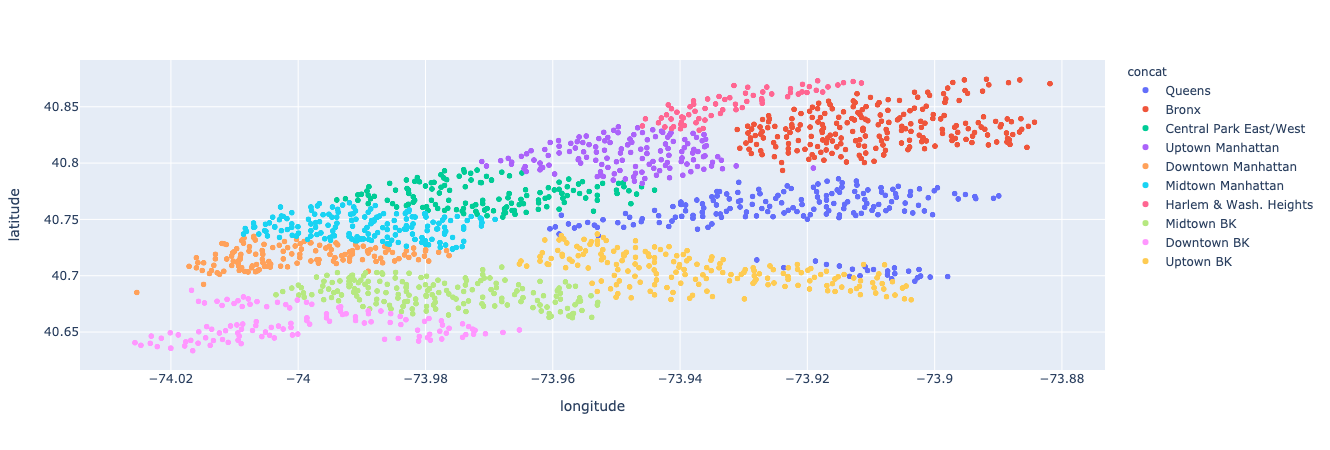

In [82]:
fig.show()

In [83]:
df_p.count()

_c0                 1527
Borough             1527
startStationName    1527
latitude            1527
longitude           1527
prediction          1527
concat              1527
dtype: int64

In [84]:
df_p.to_csv('station_df2.csv', index = False)

In [85]:
df_p.groupby('concat').count()

,_c0,Borough,startStationName,latitude,longitude,prediction
concat,,,,,,
Bronx,226,226,226,226,226,226
Central Park East/West,137,137,137,137,137,137
Downtown BK,116,116,116,116,116,116
Downtown Manhattan,138,138,138,138,138,138
Harlem & Wash. Heights,67,67,67,67,67,67
Midtown BK,172,172,172,172,172,172
Midtown Manhattan,171,171,171,171,171,171
Queens,179,179,179,179,179,179
Uptown BK,183,183,183,183,183,183
